# Model Evaluation using SkLearn

## Import of libraries to be used

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn import metrics

C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# --- By Description of Experiences---
After creating the "pickle" file with the embeddings for each of the experiences inferred, as well as the skills involved, the file is used in this notebook for evaluation of the models selected.

After importing the file, the data was plotted in order to verify that the records were correctly saved.

In [5]:
fname_doc2vec= 'Doc2VecJobTraining.pickle'
Doc2VecTrain = pickle.load( open( fname_doc2vec, "rb" ) )

<Figure size 576x432 with 0 Axes>

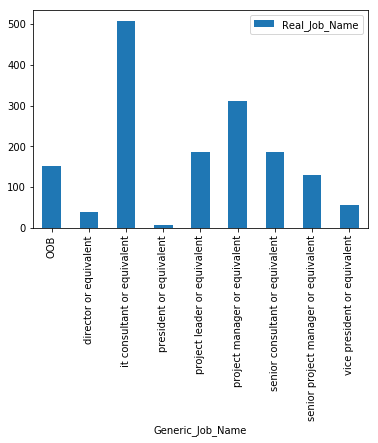

In [6]:
df = pd.DataFrame(Doc2VecTrain["Labels"])
df.columns=['Generic_Job_Name','Real_Job_Name']
fig = plt.figure(figsize=(8,6))
df.groupby('Generic_Job_Name').count().plot.bar(ylim=0)
plt.show()

It was generated a dictionary with the values refering to each of the levels, as well as it was stored in a pickle file in order to be used in the future.
A conversion of the categoric value is perfomred to assing a numerical value to be used in the prediction for trainning of the model.

In [9]:
#Declare of JobName dictionary
job_to_id = {'it consultant or equivalent':0
            ,'senior consultant or equivalent':1
            ,'project leader or equivalent':2
            ,'project manager or equivalent':3
            ,'senior project manager or equivalent':4
            ,'director or equivalent':5
            ,'vice president or equivalent':6
            ,'president or equivalent':7  
            ,'OOB':8
            }

outfile = open("CatalogJobtoId.pkl",'wb')
pickle.dump(job_to_id,outfile)
outfile.close()

In [10]:
#Assing of ID according to the dictionary defined previously
df['job_id'] = df['Generic_Job_Name'].map(job_to_id)
#A new dictionary is created for the conversion from numerical to categorical variables
job_id_df = df[['Generic_Job_Name', 'job_id']].drop_duplicates().sort_values('job_id')
#Declare of the variable to apply teh conversion
id_to_job = dict(job_id_df[['job_id', 'Generic_Job_Name']].values)

In [12]:
#The dictionary is stored as well in a pickle file 
outfile = open("CatalogIdtoJob.pkl",'wb')
pickle.dump(id_to_job,outfile)
outfile.close()

In [9]:
#The features (embedding) and the labels are obtained
features = Doc2VecTrain["Embedding"]
labels = df.job_id
features.shape

(1574, 200)

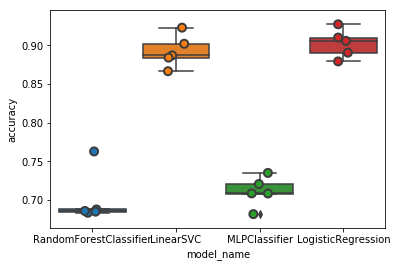

In [10]:
#Definition of the models to be used, as well as the hyperparameters used for each of them
models = [
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),
    LinearSVC(),
    MLPClassifier(hidden_layer_sizes=(3,),activation='tanh',solver ='adam',random_state=1, max_iter=750, warm_start=True),#solver ='lbfgs'
    LogisticRegression(random_state=0),
]

#5 Fold validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

#box plot for the accuracy in each of the models in each of the fold_idx
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [11]:
#Print of the mean accuracies of the models
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.892669
LogisticRegression        0.902740
MLPClassifier             0.710824
RandomForestClassifier    0.700901
Name: accuracy, dtype: float64

In [12]:
#Split of data for training and testing
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)

print("X_train: {}".format(len(X_train)))
print("X_test: {}".format(len(X_test)))
print("Total: {}".format(len(X_train)+len(X_test)))
print("Y_train: {}".format(len(y_train)))
print("Y_test: {}".format(len(y_test)))
print("Total: {}".format(len(y_train)+len(y_test)))

X_train: 1259
X_test: 315
Total: 1574
Y_train: 1259
Y_test: 315
Total: 1574


## Support Vector Machine metrics 

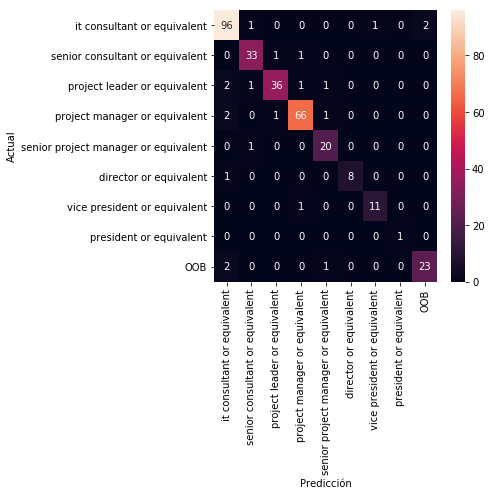

In [13]:
#Prediction with the model with the highest score in the mean accuracy
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Plot of Confusion Matrix.
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=job_id_df.Generic_Job_Name.values, yticklabels=job_id_df.Generic_Job_Name.values)
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [14]:
#Computation of Metrics.
print(metrics.classification_report(y_test, y_pred, target_names=df['Generic_Job_Name'].unique()))

                                      precision    recall  f1-score   support

       project manager or equivalent       0.93      0.96      0.95       100
        vice president or equivalent       0.92      0.94      0.93        35
senior project manager or equivalent       0.95      0.88      0.91        41
        project leader or equivalent       0.96      0.94      0.95        70
     senior consultant or equivalent       0.87      0.95      0.91        21
         it consultant or equivalent       1.00      0.89      0.94         9
             president or equivalent       0.92      0.92      0.92        12
              director or equivalent       1.00      1.00      1.00         1
                                 OOB       0.92      0.88      0.90        26

                         avg / total       0.93      0.93      0.93       315



## Logistic Regression 

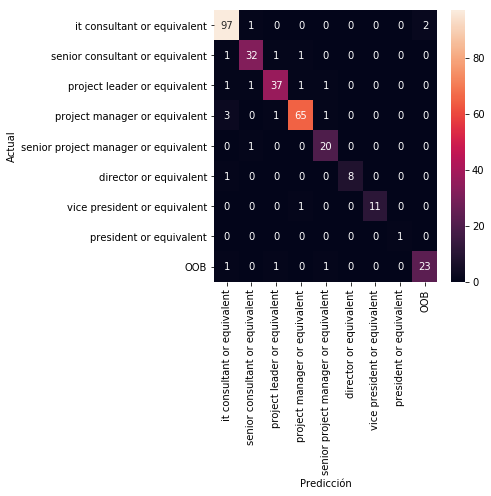

In [17]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Plot of Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=job_id_df.Generic_Job_Name.values, yticklabels=job_id_df.Generic_Job_Name.values)
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.show()

In [19]:
#Accuracy of the actual model
model.score(X_train,y_train)

0.9674344718030182

In [18]:
#computation of metrics 
print(metrics.classification_report(y_test, y_pred, target_names=df['Generic_Job_Name'].unique()))

                                      precision    recall  f1-score   support

       project manager or equivalent       0.93      0.97      0.95       100
        vice president or equivalent       0.91      0.91      0.91        35
senior project manager or equivalent       0.93      0.90      0.91        41
        project leader or equivalent       0.96      0.93      0.94        70
     senior consultant or equivalent       0.87      0.95      0.91        21
         it consultant or equivalent       1.00      0.89      0.94         9
             president or equivalent       1.00      0.92      0.96        12
              director or equivalent       1.00      1.00      1.00         1
                                 OOB       0.92      0.88      0.90        26

                         avg / total       0.93      0.93      0.93       315



In [20]:
# Save the model as a 'Pickle'
from sklearn.externals import joblib
# Output a pickle file for the model
joblib.dump(model, 'LogisticRegressionModelExperience.pkl') 


['LogisticRegressionModelExperience.pkl']

# ---By Skills---

In [22]:
fname_doc2vec_skill= 'Doc2VecJobSkillTraining.pickle'
Doc2Vec = pickle.load( open( fname_doc2vec_skill, "rb" ) )

<Figure size 576x432 with 0 Axes>

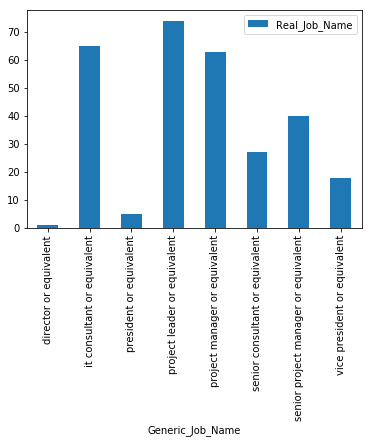

In [23]:
df = pd.DataFrame(Doc2Vec["Labels"])
df.columns=['Generic_Job_Name','Real_Job_Name']
fig = plt.figure(figsize=(8,6))
df.groupby('Generic_Job_Name').count().plot.bar(ylim=0)
plt.show()

In [26]:
#Assign of ID from labels
df['job_id'] = df['Generic_Job_Name'].map(job_to_id)
#Creation of additional dictionary
job_id_df = df[['Generic_Job_Name', 'job_id']].drop_duplicates().sort_values('job_id')
#Variable with the values of the dictionary
id_to_job = dict(job_id_df[['job_id', 'Generic_Job_Name']].values)

In [27]:
features = Doc2Vec["Embedding"]
labels = df.job_id
features.shape

(293, 200)

In [28]:
Y=[]
for d in Doc2VecTrain["Labels"]:
    Y.append(d[0])
Y=np.array(Y)

C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\neural_network\multilayer_perceptro

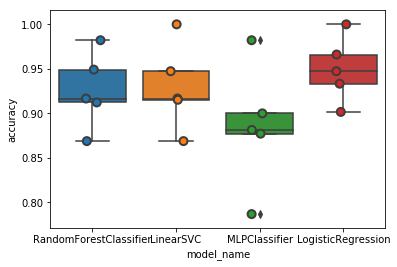

In [29]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MLPClassifier(hidden_layer_sizes=(5,), random_state=1,activation='tanh',solver ='adam', max_iter=750, warm_start=True),
    LogisticRegression(random_state=0),
]

#Cross Validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

#Box plot of accuracies in fold_idx
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [30]:
#Mean accuracies for each of models
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.929628
LogisticRegression        0.949689
MLPClassifier             0.885515
RandomForestClassifier    0.925819
Name: accuracy, dtype: float64

In [31]:
#Split of data for training and testing
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
print("X_train: {}".format(len(X_train)))
print("X_test: {}".format(len(X_test)))
print("Total: {}".format(len(X_train)+len(X_test)))
print("Y_train: {}".format(len(y_train)))
print("Y_test: {}".format(len(y_test)))
print("Total: {}".format(len(y_train)+len(y_test)))

X_train: 234
X_test: 59
Total: 293
Y_train: 234
Y_test: 59
Total: 293


## Support Vector Machine

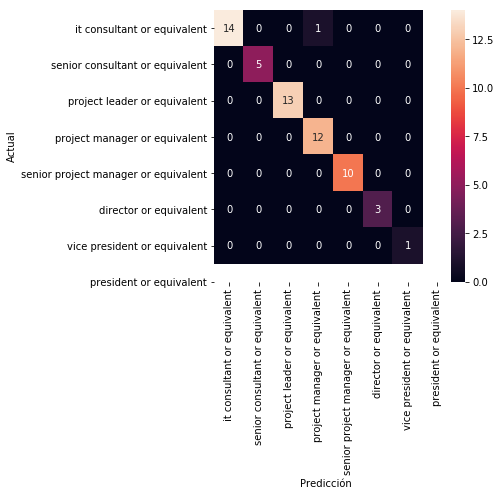

In [32]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Plot of confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=job_id_df.Generic_Job_Name.values, yticklabels=job_id_df.Generic_Job_Name.values)
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.show()

In [33]:
#Computation of metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Generic_Job_Name'].unique()))

                                      precision    recall  f1-score   support

       project manager or equivalent       1.00      0.93      0.97        15
senior project manager or equivalent       1.00      1.00      1.00         5
        vice president or equivalent       1.00      1.00      1.00        13
        project leader or equivalent       0.92      1.00      0.96        12
     senior consultant or equivalent       1.00      1.00      1.00        10
         it consultant or equivalent       1.00      1.00      1.00         3
             president or equivalent       1.00      1.00      1.00         1

                         avg / total       0.98      0.98      0.98        59



C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 7, does not match size of target_names, 8
  .format(len(labels), len(target_names))


## Logistic Regression

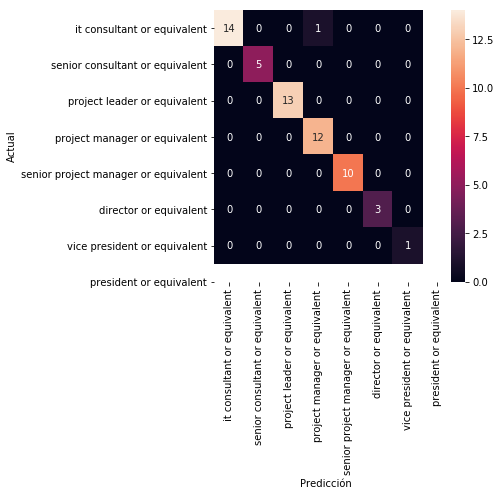

In [34]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Plot of Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=job_id_df.Generic_Job_Name.values, yticklabels=job_id_df.Generic_Job_Name.values)
plt.ylabel('Actual')
plt.xlabel('Predicción')
plt.show()

In [35]:
#Para el cálculo de métricas
print(metrics.classification_report(y_test, y_pred, target_names=df['Generic_Job_Name'].unique()))

                                      precision    recall  f1-score   support

       project manager or equivalent       1.00      0.93      0.97        15
senior project manager or equivalent       1.00      1.00      1.00         5
        vice president or equivalent       1.00      1.00      1.00        13
        project leader or equivalent       0.92      1.00      0.96        12
     senior consultant or equivalent       1.00      1.00      1.00        10
         it consultant or equivalent       1.00      1.00      1.00         3
             president or equivalent       1.00      1.00      1.00         1

                         avg / total       0.98      0.98      0.98        59



C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 7, does not match size of target_names, 8
  .format(len(labels), len(target_names))


In [38]:
#Accuracy of the actual model 
model.score(X_train,y_train)

0.9658119658119658

In [39]:
# Save the model as a 'Pickle'
from sklearn.externals import joblib
# Output a pickle file for the model
joblib.dump(model, 'LogisticRegressionModelSkills.pkl') 

['LogisticRegressionModelSkills.pkl']